In [10]:
import netCDF4 as netcdf
from concorde.plots import plot2D
from kalpana.tools import readNodes_fort14
from kalpana.export import fort14togdf
import matplotlib.pyplot as plt
import pandas as pd
import cmocean
import numpy as np
from pathlib import Path
import os

#### Plots tide simulation

In [8]:
nc = netcdf.Dataset(r'../models/adcirc/concorde/batch02/01/_postprocessing/_results/base/fort.63.nc')
var = 'zeta'
levels = np.arange(-2, 2.25, 0.25)

In [3]:
f14 = readNodes_fort14(r'../models/adcirc/concorde/batch02/01/_template/fort.14')

In [12]:
gdfMeshBase = fort14togdf(r'../models/adcirc/concorde/batch02/01/_template/fort.14', 4326, 4326)
gdfMeshBase.to_file(r'/mnt/drive1/Insyncs/NCSU/thesis/gis/gpkg/meshBaseSim_batch02.gpkg', driver = 'GPKG')

In [4]:
f14.head()

,x,y,z
0,-82.646213,27.462899,-2.886998
1,-82.645676,27.461891,-2.964247
2,-82.648632,27.465797,-0.688296
3,-82.644279,27.461134,-2.865377
4,-82.645551,27.460673,-2.547972


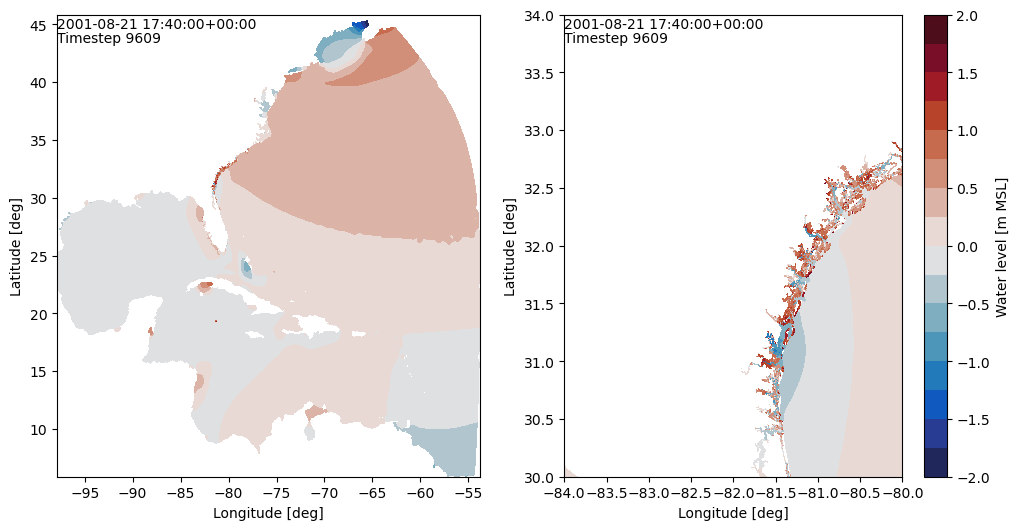

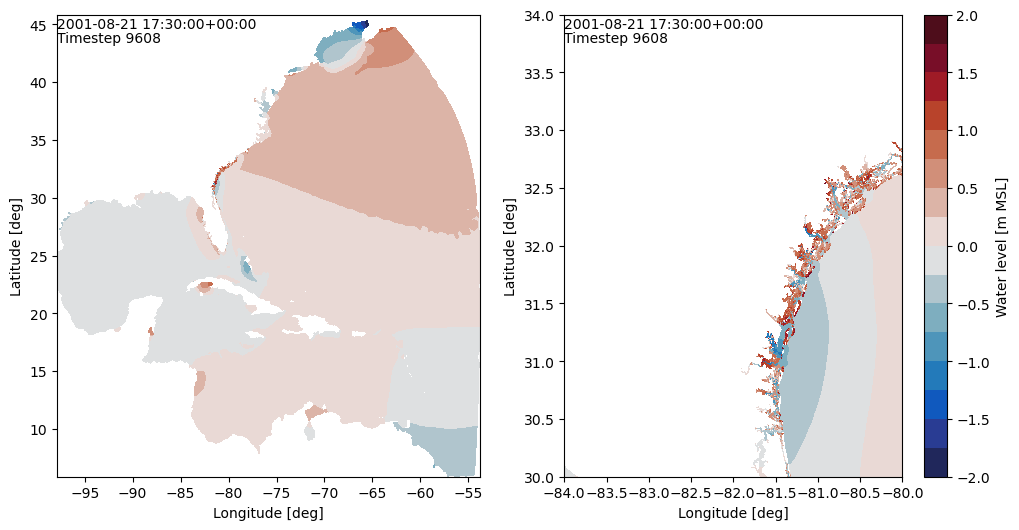

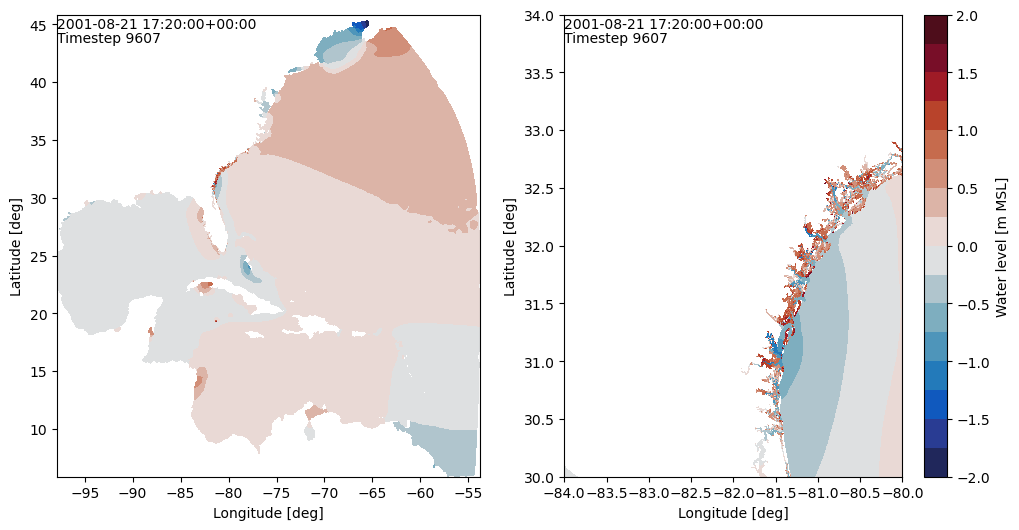

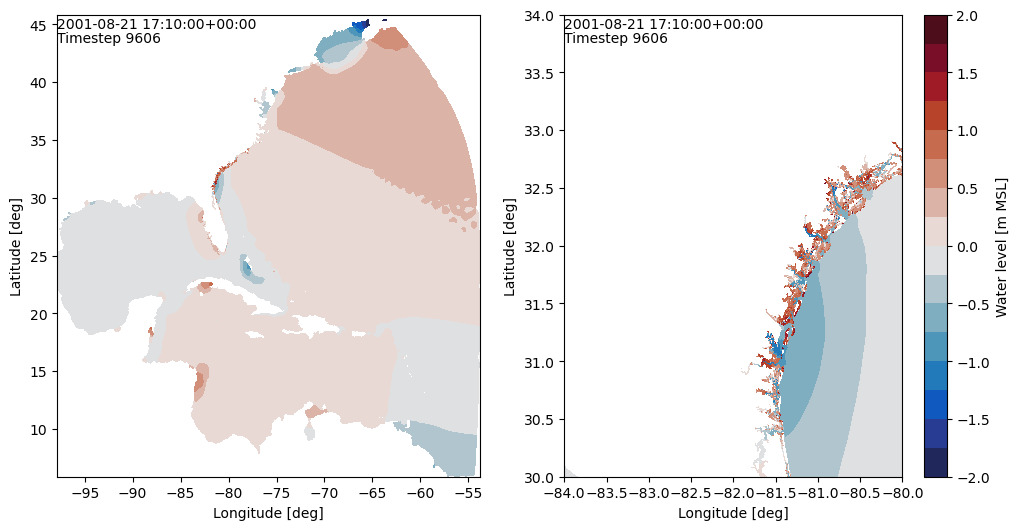

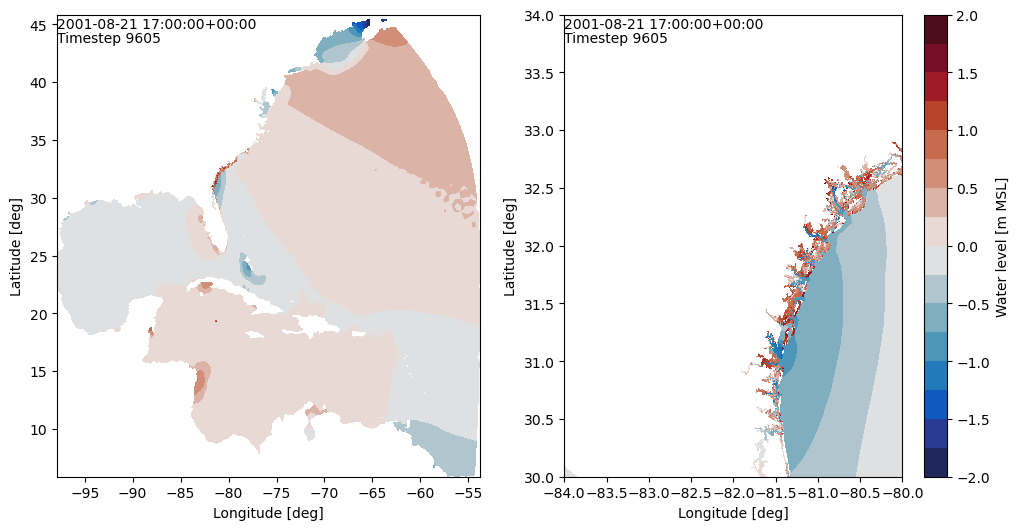

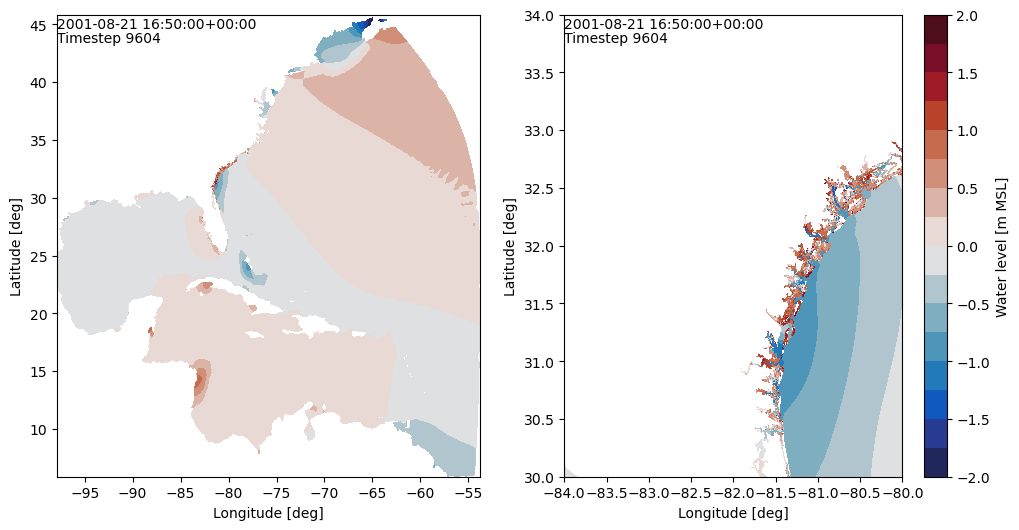

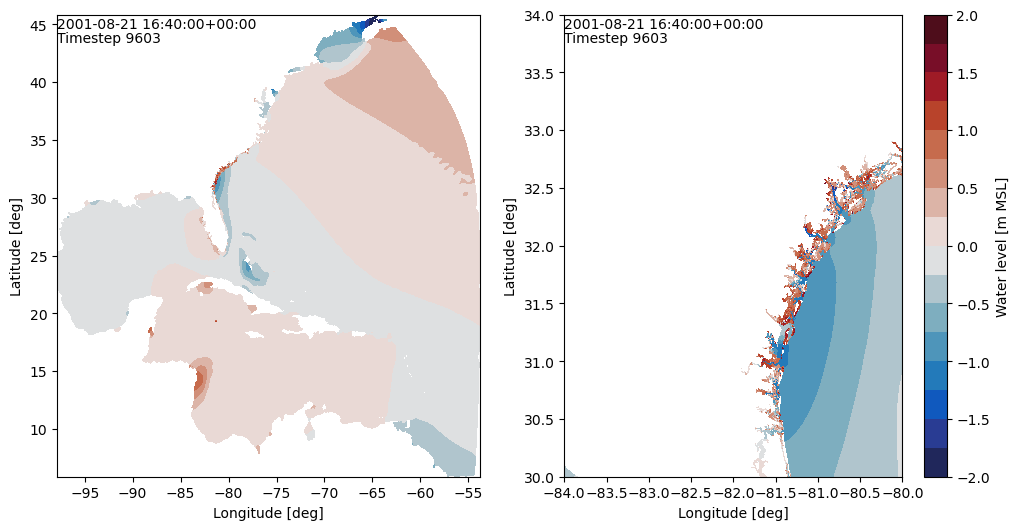

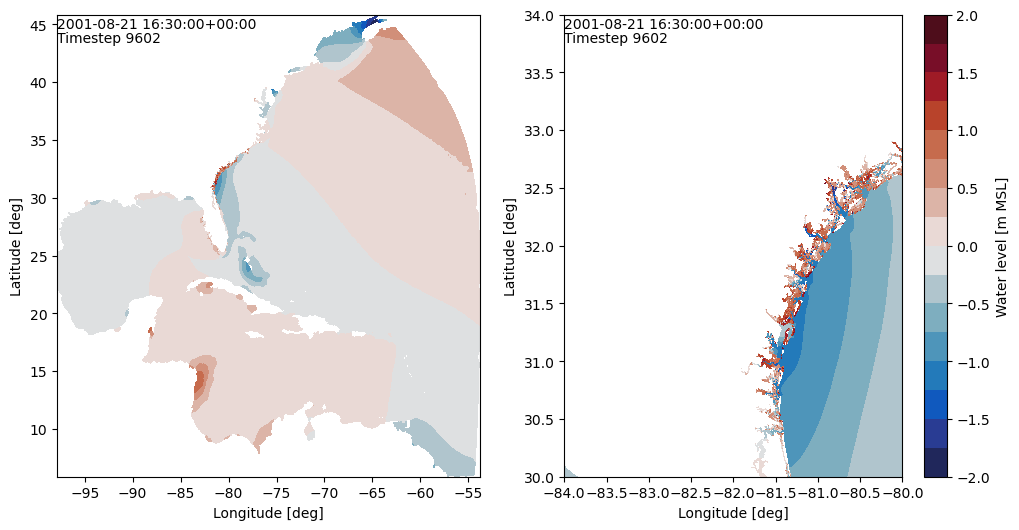

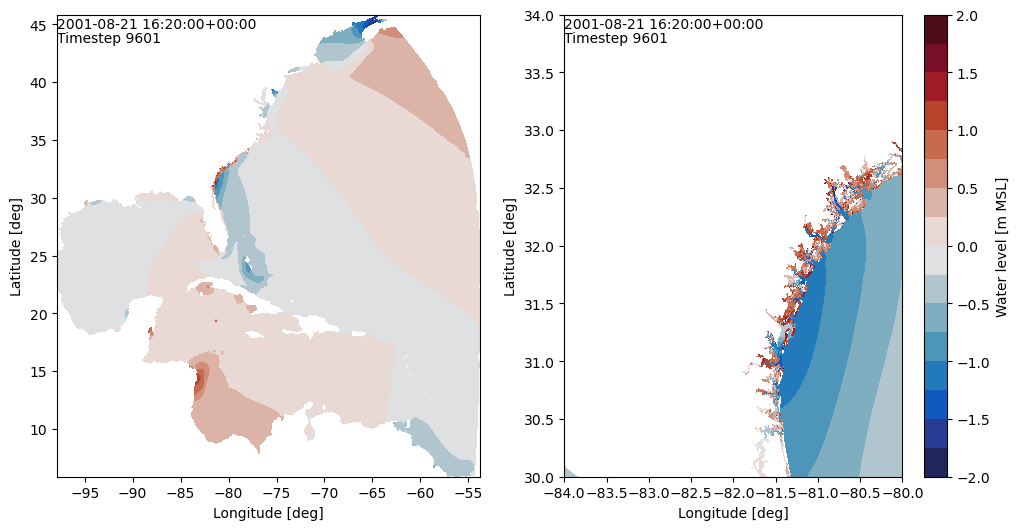

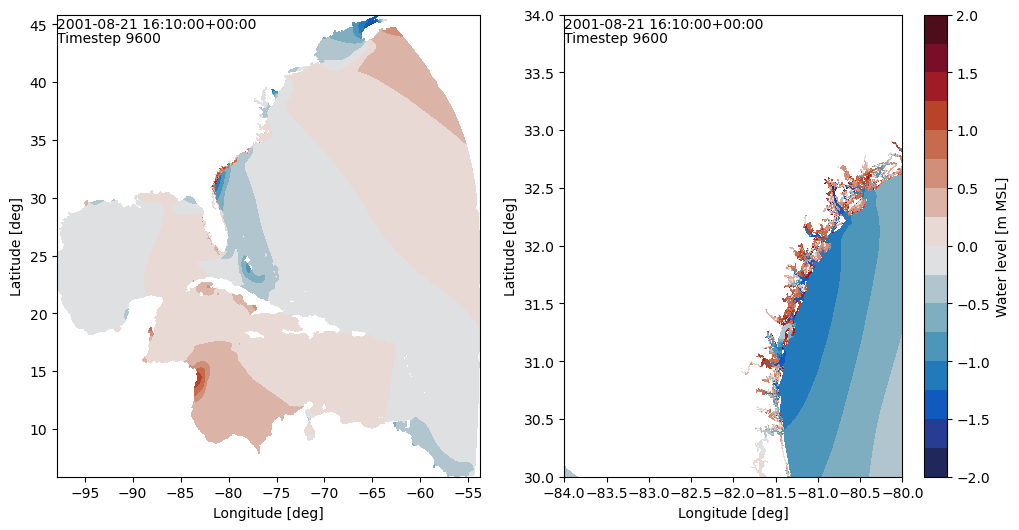

In [9]:
nplots = 10
i = 0
for t in range(nc['time'].size):
    
    if i < nplots:
       t2 = nc['time'].size - t - 1

       fig, ax = plt.subplots(figsize = (12,6), ncols = 2)
       plot2D(nc, var, levels, ts = t2, cbar = False, cmap = cmocean.cm.balance, ax = ax[0])
       
       # xs = f14.loc[1018388 - 1, 'x']
       xs = -82
       ys = 32
       # ys = f14.loc[1018388 - 1, 'y']
       delta = 2
       
       plot2D(nc, var, levels, ts = t2, cbar = True, cb_label = 'Water level [m MSL]',
              cmap = cmocean.cm.balance, ax = ax[1], fig = fig, xlims = [xs - delta, xs + delta],
              ylims = [ys - delta, ys + delta])
       
       # ax[0].scatter([xs], [ys], alpha = 0, edgecolor = 'k')
       # ax[1].scatter([xs], [ys], alpha = 0, edgecolor = 'k')
       i += 1
    else:
        break


#### Hurricane simulations

In [9]:
pin = Path(r'../models/adcirc/concorde/batch02/01/')
f14 = readNodes_fort14(r'../models/adcirc/concorde/batch02/01/_template/fort.14')

In [3]:
dflogs = []
logs = sorted([x for x in os.listdir(pin) if x.startswith('logFiles')])
for log in logs:
    dummy = pd.read_csv(pin/log, index_col = 0)
    dflogs.append(dummy)
dflogs = pd.concat(dflogs, axis = 0, ignore_index = True)
dflogs.index = range(len(dflogs))

In [4]:
dflogs2 = dflogs[dflogs['status'] == 'ADCIRC blow-up']

In [5]:
var = 'zeta'
levels = np.arange(-2, 2.25, 0.25)

In [34]:
for r in dflogs2['run']:
    run = str(r).zfill(4)
    f22 = pd.read_csv(pin/run/'fort.22_fullTrack', header = None)
    lats = [int(x[:-1])/10 for x in f22.iloc[:, 6]]
    lons = [-1*int(x[:-1])/10 for x in f22.iloc[:, 7]]
    nc1 = netcdf.Dataset(pin/run/'fort.63.nc')
    nc2 = netcdf.Dataset(pin/run/'fort.74.nc')
    pout = pin/'_postprocessing'/run/'_plots'
    try:
        os.makedirs(pout)
    except:
        pass

    logs = [pin/run/x for x in os.listdir(pin/run) if x.startswith(f'{run}.') and
        '.csh' not in x and '.sh' not in x]
    sdates = []
    for log in logs:
        sdates.append(os.path.getmtime(log))
    lastLog = logs[np.argmax(sdates)]

    tlast = nc1['time'].size - 1

    with open(lastLog, 'r') as fin:
        lines = fin.readlines()
        for iline, line in enumerate(lines):
            if 'WARNING: Elevation.gt.WarnElev' in line:
                break
    node = int(line.split()[line.split().index('NODE') + 1])
    xs = f14.loc[node - 1, 'x']
    ys = f14.loc[node - 1, 'y']
    delta = 1

    for t in np.arange(tlast, tlast - 20, -1):
        fig, ax = plt.subplots(figsize = (12, 6), ncols = 2)
        plot2D(nc1, var, levels, ts = t, cbar = False, ax = ax[0],
                    cmap = cmocean.cm.balance, ncvec = nc2, dxvec = 1, dyvec = 1, vecsc = 500)
        
        plot2D(nc1, var, levels, ts = t, cbar = True, cb_label = 'Water level [m MSL]',
            cmap = cmocean.cm.balance, ax = ax[1], fig = fig, xlims = [xs - delta, xs + delta],
            ylims = [ys - delta, ys + delta], ncvec = nc2, dxvec = 0.1, dyvec = 0.1, vecsc = 25)

        ax[0].plot(lons, lats, c = 'k', linewidth = 0.5)
        ax[0].scatter([xs], [ys], c = 'k')
        ax[0].set_aspect('equal')
        ax[1].plot(lons, lats, c = 'k', linewidth = 0.5)
        ax[1].scatter([xs], [ys], c = 'k')
        ax[1].set_aspect('equal')
        plt.savefig(pout/f'eta_ts{t:05d}.png', dpi = 100)
        plt.close()

    break